Estimating likelihood of death as a function of days since COVID-19 diagnosis
============================

Look, this is really sloppy, has some kind of ad-hoc smoothing weights, and doesn't have enough comments.

I'm going to put it up, but with some strong caveats that it's not really ready for public consumption yet.

Enjoy!

In [57]:
import numpy as np
from matplotlib import pyplot as plt
import csv
from datetime import datetime, timedelta
import nbconvert

In [58]:
fname = "covid-19-data/us-counties.csv"
pop_data_fname = "us-census-data/county_data.csv"

In [59]:
county_pops = {}
csv_reader = csv.DictReader(open(pop_data_fname, 'r', newline='', encoding='ISO-8859-1'))
for entry in csv_reader:
    # print(entry['STNAME'] + " - " + entry['CTYNAME'])
    state_entry = county_pops.get(entry['STNAME'], {})
    county_name = entry["CTYNAME"].replace(" County", "")
    state_entry[county_name] = float(entry["POPESTIMATE2019"])
    county_pops[entry['STNAME']] = state_entry
county_pops["New York"]["New York City"] = 8.399e6
print("LA -> " + str(county_pops["California"]["Los Angeles"]))
print("Catoosa -> " + str(county_pops["Georgia"]["Catoosa"]))
print("Grimes -> " + str(county_pops["Texas"]["Grimes"]))

LA -> 10039107.0
Catoosa -> 67580.0
Grimes -> 28880.0


In [60]:
population_drop_thresh = 30000
csv_reader = csv.DictReader(open(fname))
data = []
for entry in csv_reader:
    if entry['county'].lower() == "unknown":
        continue
    raw_pop = county_pops.get(entry['state'], {}).get(entry['county'], 0.0)
    if True:
        if raw_pop <= 0.0 or raw_pop < population_drop_thresh:
            continue
        entry['population'] = raw_pop
    entry['county'] = entry['state'] + " - " + entry['county']
    data.append(entry)


In [61]:
def entry_to_days(entry):
    """Converts a YYYY-mm-dd date into an integer with 0 being 2020-01-01"""
    d1 = datetime.strptime(entry['date'], "%Y-%m-%d")
    d0 = datetime.strptime("2020-01-01", "%Y-%m-%d")
    return(d1 - d0).days

def date_from_daynum(daynum):
    return datetime.strptime("2020-01-01", "%Y-%m-%d") + timedelta(days=daynum)
    

In [62]:
data[0]

{'date': '2020-01-21',
 'county': 'Washington - Snohomish',
 'state': 'Washington',
 'fips': '53061',
 'cases': '1',
 'deaths': '0',
 'population': 822083.0}

In [63]:
# Now we extract data for all counties in this state
counties = {}
for d in data:
    l = counties.get(d['county'], [])
    val = float(d["cases"])
    other_val = float(d["deaths"])
    l.append([entry_to_days(d), val, other_val])
    counties[d['county']] = l
for county in counties:
    counties[county] = sorted(counties[county])

In [64]:
[k for k in counties.keys()][0], counties[[k for k in counties.keys()][0]][:3]

('Washington - Snohomish', [[20, 1.0, 0.0], [21, 1.0, 0.0], [22, 1.0, 0.0]])

In [65]:
changes = {}
smoothing = 1
for county in counties:
    ds = [e[2] for e in counties[county]]
    cs = [e[1] for e in counties[county]]
    ts = [e[0] for e in counties[county]]
    d_rates = [ds[t] - ds[t-smoothing] for t in range(smoothing, len(ds))]
    c_rates = [cs[t] - cs[t-smoothing] for t in range(smoothing, len(cs))]
    changes[county] = [[ts[smoothing+i], c_rates[i], d_rates[i]] for i in range(len(d_rates))]

In [66]:
def mat_stacks_for_county(county, window=30):
    lhs = []
    rhs = []
    for e in changes[county]:
        t = e[0]
        d = e[2]
        if d < 0:
            continue
        v = [0 for i in range(window)]
        denom = max(d, 100)
        for e2 in changes[county]:
            idx = t - e2[0]
            if idx >= window or idx < 0:
                continue
            v[idx] = e2[1]/denom
        lhs.append([d/denom])
        rhs.append(v)
    return (np.array(lhs), np.array(rhs))

In [67]:
v,m = mat_stacks_for_county("New York - New York City")

In [68]:
v.shape, m.shape

((360, 1), (360, 30))

In [69]:
c = np.dot(np.linalg.pinv(m), v)

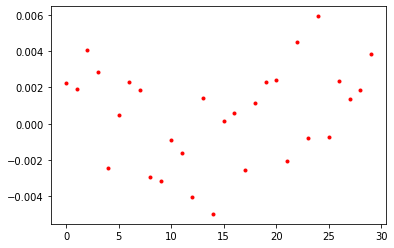

In [70]:
plt.plot([i for i in range(len(c))], c, 'r.')

In [71]:
np.array([])

array([], dtype=float64)

In [72]:
np.hstack([np.eye(3), np.eye(3)]), np.hstack([np.zeros((1,1)), np.zeros((1,1))])

(array([[1., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 1.]]),
 array([[0., 0.]]))

In [73]:
def giant_matrix_system(window=120, smooth_weight=500, end_smooth=25000, state=None):
    v_accum = None
    m_accum = None
    for county in counties.keys():
        if state is not None and state not in county.split(" - ")[0]:
            continue
        v,m = mat_stacks_for_county(county, window=window)
        if v_accum is None:
            v_accum = np.copy(v)
            m_accum = np.copy(m)
            continue
        v_accum = np.vstack([v_accum, v])
        m_accum = np.vstack([m_accum, m])
    for idx in range(1, window):
        row = np.zeros((1, window))
        v = np.zeros((1,1))
        row[0, idx] = smooth_weight
        row[0, idx - 1] = -smooth_weight
        v_accum = np.vstack([v_accum, v])
        m_accum = np.vstack([m_accum, row])
    v_accum = np.vstack([v_accum, np.zeros((2,1))])
    last_rows = np.zeros((2, window))
    last_rows[0, 0] = end_smooth
    last_rows[1, -1] = end_smooth
    m_accum = np.vstack([m_accum, last_rows])
    return (v_accum, m_accum)

In [74]:
(v, m) = giant_matrix_system(smooth_weight=5000, end_smooth=50000)

In [75]:
v.shape, m.shape

((482096, 1), (482096, 120))

In [76]:
c = np.dot(np.linalg.pinv(m), v)

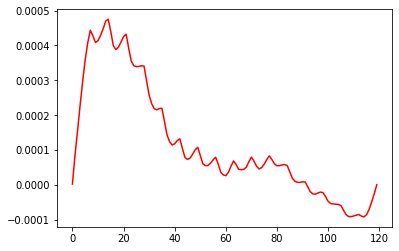

In [77]:
plt.plot([i for i in range(len(c))], c, 'r-')

This is the part you came here for
==========================

$X$ axis is "days since COVID-19 diagnosis"

$Y$ axis is "probability of entering the death statistics on that day"

Was planning on using this as a component for forecasting, but, haven't gotten around to it

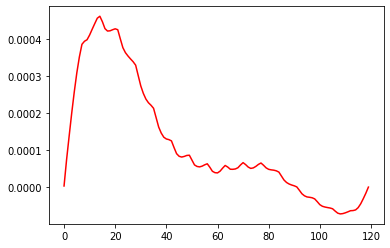

In [78]:
(v, m) = giant_matrix_system(smooth_weight=7500, end_smooth=50000)
c = np.dot(np.linalg.pinv(m), v)
plt.plot([i for i in range(len(c))], c, 'r-')

In [79]:
sum(c)

array([0.01422187])

In [80]:
sum(c[:25]), sum(c[25:])

(array([0.00885493]), array([0.00536694]))

In [81]:
sum([i * c[i] for i in range(len(c))]) / sum(c)

array([19.19350191])

In [82]:
sum(c[:15]), sum(c[15:])

(array([0.00471283]), array([0.00950904]))

In [83]:
[k for k in counties.keys()][0].split(" - ")[0]

'Washington'

In [84]:
"non" in "banana"

False

In [85]:
def solve_state(state, smooth_weight=2000, end_smooth=40000):
    (v, m) = giant_matrix_system(smooth_weight=smooth_weight, end_smooth=end_smooth, state=state)
    print("made matrix system " + str((v.shape, m.shape)))
    c = np.dot(np.linalg.pinv(m), v)
    print("Solved matrix system")
    plt.plot([i for i in range(len(c))], c, 'r-')
    print("sum(c) is " + str(sum(c)))
    print("expected days is " + str(sum([i * c[i] for i in range(len(c))]) / sum(c)))
    return c

made matrix system ((16916, 1), (16916, 120))
Solved matrix system
sum(c) is [0.01355428]
expected days is [19.16799904]


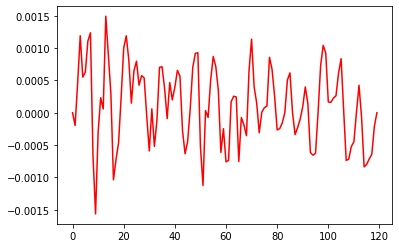

In [86]:
c_cal = solve_state("California", smooth_weight=200)

made matrix system ((16916, 1), (16916, 120))
Solved matrix system
sum(c) is [0.01362028]
expected days is [22.27736924]


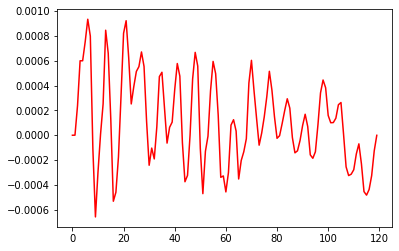

In [87]:
c_cal = solve_state("California", smooth_weight=500)

made matrix system ((16916, 1), (16916, 120))
Solved matrix system
sum(c) is [0.01378052]
expected days is [27.41728702]


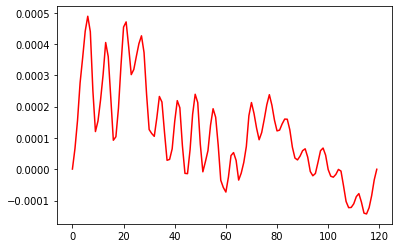

In [88]:
c_cal = solve_state("California", smooth_weight=1500)

made matrix system ((16916, 1), (16916, 120))
Solved matrix system
sum(c) is [0.01390834]
expected days is [29.47191119]


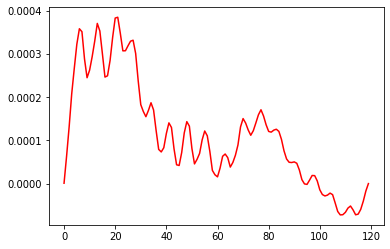

In [89]:
c_cal = solve_state("California", smooth_weight=2500)

made matrix system ((16916, 1), (16916, 120))
Solved matrix system
sum(c) is [0.01414839]
expected days is [32.54364519]


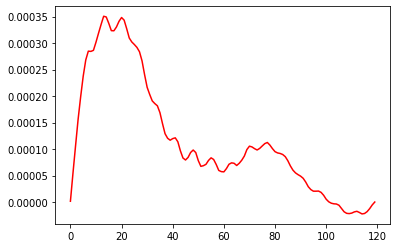

In [90]:
c_cal = solve_state("California", smooth_weight=5000)

made matrix system ((16916, 1), (16916, 120))
Solved matrix system
sum(c) is [0.01425572]
expected days is [35.43836113]


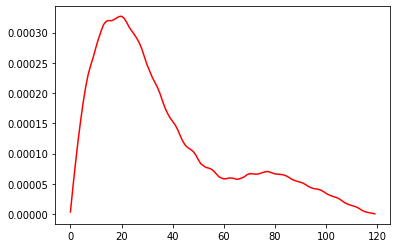

In [108]:
c_cal = solve_state("California", smooth_weight=10000)

made matrix system ((32882, 1), (32882, 120))
Solved matrix system
sum(c) is [0.01269819]
expected days is [6.77631356]


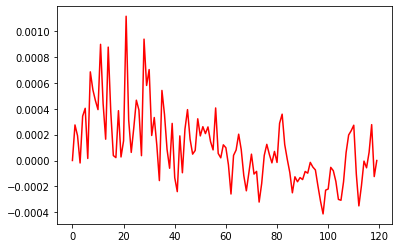

In [91]:
c_tex = solve_state("Texas", smooth_weight=200)

made matrix system ((32882, 1), (32882, 120))
Solved matrix system
sum(c) is [0.01270016]
expected days is [7.0090811]


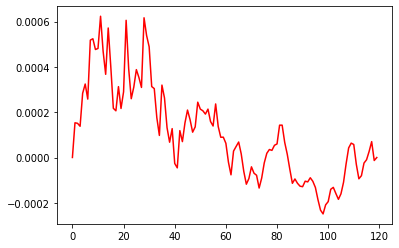

In [92]:
c_tex = solve_state("Texas", smooth_weight=500)

made matrix system ((32882, 1), (32882, 120))
Solved matrix system
sum(c) is [0.01269182]
expected days is [7.40546383]


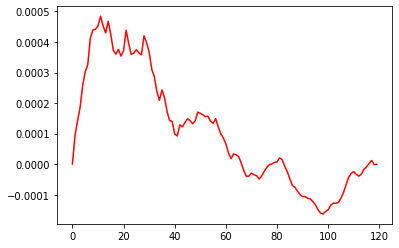

In [93]:
c_tex = solve_state("Texas", smooth_weight=1200)

made matrix system ((19040, 1), (19040, 120))
Solved matrix system
sum(c) is [0.01750434]
expected days is [15.96931334]


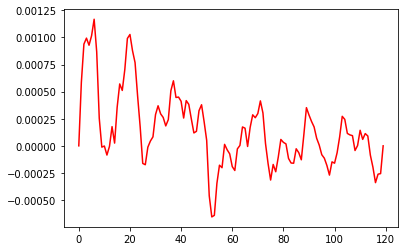

In [94]:
c_ny = solve_state("New York", smooth_weight=200)

made matrix system ((19040, 1), (19040, 120))
Solved matrix system
sum(c) is [0.01754206]
expected days is [16.638819]


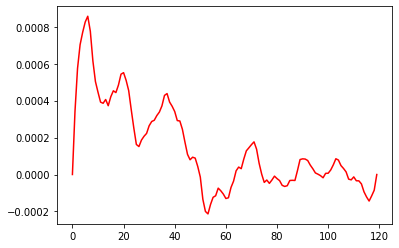

In [95]:
c_ny = solve_state("New York", smooth_weight=500)

made matrix system ((19040, 1), (19040, 120))
Solved matrix system
sum(c) is [0.01756539]
expected days is [17.64102701]


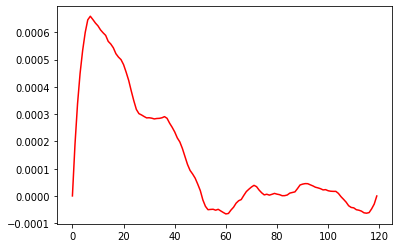

In [96]:
c_ny = solve_state("New York", smooth_weight=1200)

made matrix system ((17129, 1), (17129, 120))
Solved matrix system
sum(c) is [0.01364043]
expected days is [24.7609186]


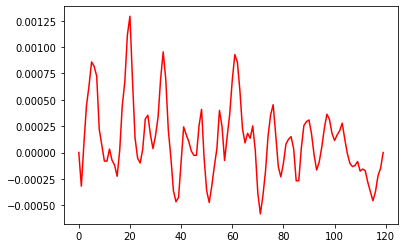

In [97]:
c_fl = solve_state("Florida", smooth_weight=200)

made matrix system ((17129, 1), (17129, 120))
Solved matrix system
sum(c) is [0.01368643]
expected days is [25.95850855]


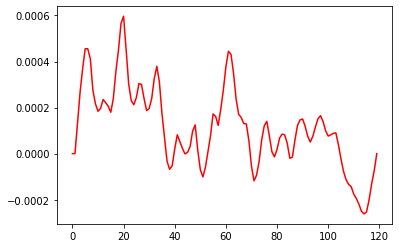

In [98]:
c_fl = solve_state("Florida", smooth_weight=500)

made matrix system ((17129, 1), (17129, 120))
Solved matrix system
sum(c) is [0.01377911]
expected days is [27.97667551]


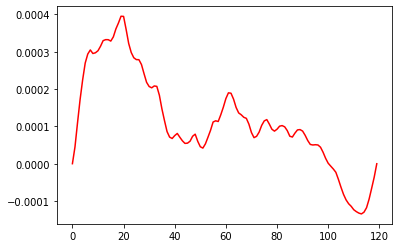

In [99]:
c_fl = solve_state("Florida", smooth_weight=1200)

made matrix system ((4647, 1), (4647, 120))
Solved matrix system
sum(c) is [0.01746884]
expected days is [21.88605572]


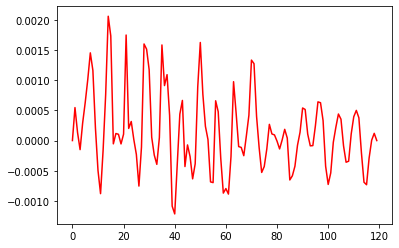

In [100]:
c_az = solve_state("Arizona", smooth_weight=200)

made matrix system ((4647, 1), (4647, 120))
Solved matrix system
sum(c) is [0.01743739]
expected days is [23.31900979]


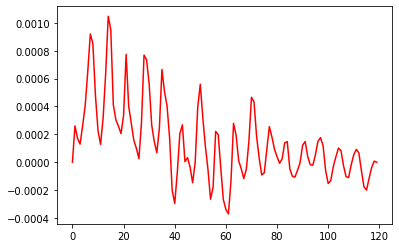

In [101]:
c_az = solve_state("Arizona", smooth_weight=500)

made matrix system ((4647, 1), (4647, 120))
Solved matrix system
sum(c) is [0.01746784]
expected days is [24.51729496]


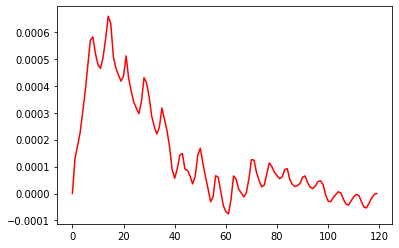

In [102]:
c_az = solve_state("Arizona", smooth_weight=1200)

made matrix system ((4977, 1), (4977, 120))
Solved matrix system
sum(c) is [0.01764136]
expected days is [27.75459131]


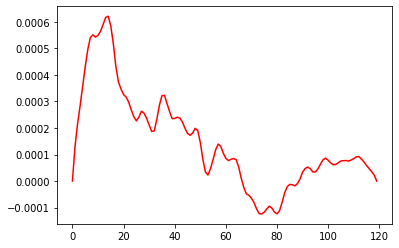

In [103]:
c_nm = solve_state("New Mexico", smooth_weight=200)

made matrix system ((4977, 1), (4977, 120))
Solved matrix system
sum(c) is [0.01713094]
expected days is [27.33328832]


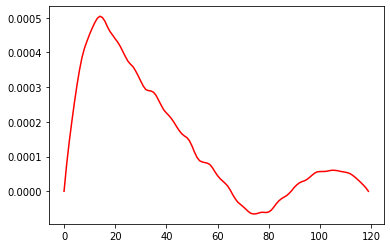

In [104]:
c_nm = solve_state("New Mexico", smooth_weight=500)

made matrix system ((4977, 1), (4977, 120))
Solved matrix system
sum(c) is [0.01795898]
expected days is [28.76942911]


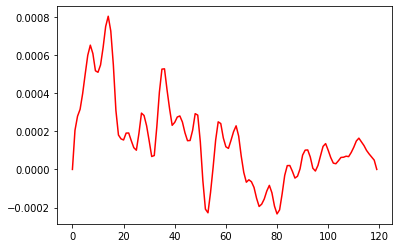

In [105]:
c_nm = solve_state("New Mexico", smooth_weight=100)

made matrix system ((4977, 1), (4977, 120))
Solved matrix system
sum(c) is [0.01829353]
expected days is [30.3178874]


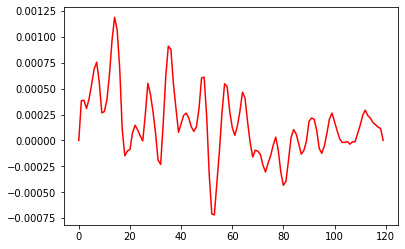

In [106]:
c_nm = solve_state("New Mexico", smooth_weight=50)